# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

In [2]:
# Load graph with genres without including isolated nodes
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_band_graph_isolated_genres.json.gz"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    print("Graph file not found.")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


In [3]:
from collections import Counter


total_genres = 0
nodes_with_genres = 0
distinct_genres_set = set()
for i, (node, genres) in enumerate(G_bands.nodes(data=True)):
    if "genres" in genres:
        nodes_with_genres += 1
        total_genres += len(genres["genres"])
        distinct_genres_set.update(genres["genres"])
avg_genres = total_genres / nodes_with_genres if nodes_with_genres > 0 else 0
distinct_genres = len(distinct_genres_set)
# Report statistics
print("\nGenre Extraction Statistics:")
print(f"- Number of nodes with genres: {nodes_with_genres}")
print(f"- Average number of genres per node: {avg_genres:.2f}")
print(f"- Total distinct genres: {distinct_genres}")


Genre Extraction Statistics:
- Number of nodes with genres: 467
- Average number of genres per node: 3.70
- Total distinct genres: 244


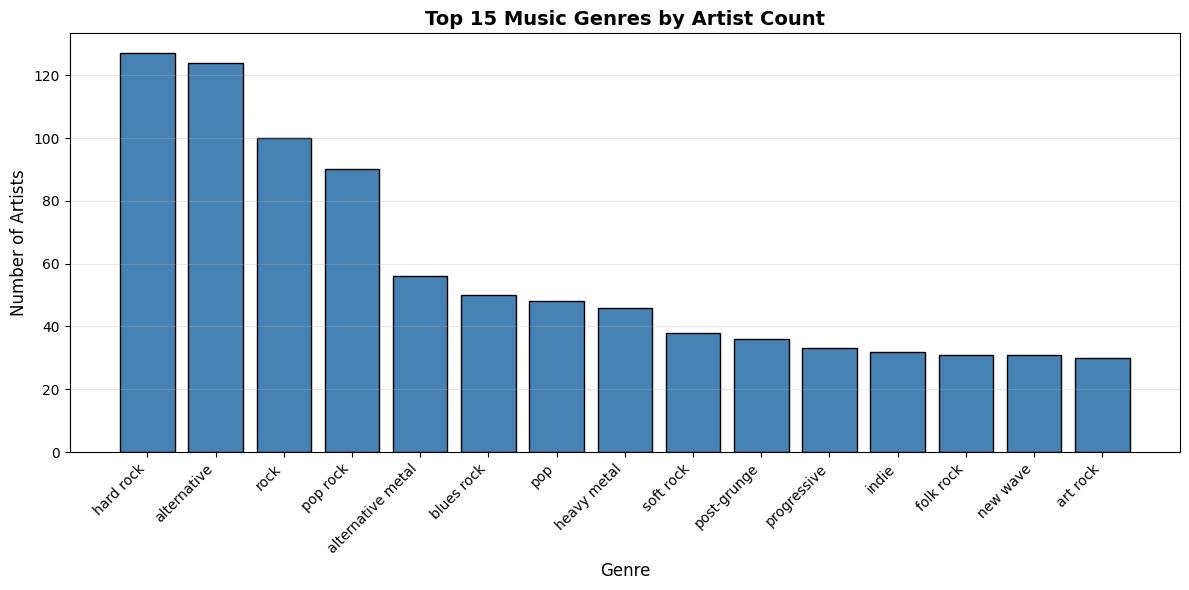

In [4]:
import matplotlib.pyplot as plt
# Count genre occurrences
genre_counter = Counter()
for node, genres in G_bands.nodes(data=True):
    if "genres" in genres:
        genre_counter.update(genres["genres"])
# Get top 15 genres
top_15_genres = genre_counter.most_common(15)
# Create histogram for top 15 genres
plt.figure(figsize=(12, 6))
genres_names = [g[0] for g in top_15_genres]
genres_values = [g[1] for g in top_15_genres]

plt.bar(range(len(genres_names)), genres_values, color="steelblue", edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.title("Top 15 Music Genres by Artist Count", fontsize=14, fontweight="bold")
plt.xticks(range(len(genres_names)), genres_names, rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.show()

In [5]:
# filter the graph to only include nodes with genres
G_undirected = G_bands.to_undirected()


nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

# create genres dictionary
genres_dict = {}
for node, data in G_genres.nodes(data=True):
    genres_dict[node] = data["genres"]
# get top 6 genres
genre_counts = Counter()
for genres in genres_dict.values():
    genre_counts.update(genres)




In [6]:
# ============================================================================
# MODULARITY CALCULATION FUNCTION (Equation 9.12)
# ============================================================================
def calculate_modularity(G, partition):
    """
    Calculate modularity using equation 9.12 from Network Science book.

    M = Σ_c [L_c/m - (k_c/2*L)²]

    where:
    - L_c = number of edges within community c
    - L = total number of edges/links
    - k_c = sum of degrees of nodes in community c

    Parameters:
    - G: NetworkX graph
    - partition: dict mapping node -> community
    Returns:
    - modularity value (float)
    """
    if len(G.edges()) == 0:
        return 0.0

    L = G.number_of_edges()  # Total number of edges

    # Group nodes by community
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    modularity = 0.0
    # Calculate modularity for each community
    for comm, nodes_in_comm in communities.items():
        # l_c: number of edges within the community
        L_c = 0
        for u in nodes_in_comm:
            for v in nodes_in_comm:
                if G.has_edge(u, v):
                    L_c += 1
        L_c = L_c / 2  # Each edge counted twice in undirected graph

        # d_c: sum of degrees of all nodes in community
        k_c = sum(G.degree(node) for node in nodes_in_comm)

        # Add contribution to modularity: l_c/m - (d_c/2m)²
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2

    return modularity

In [7]:
# PARTITION STRATEGY 1 : FIRST GENRE
import random
from collections import Counter

print("PARTITION STRATEGY 1 : FIRST GENRE")
print("=" * 40)

partition_first = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_first[node] = genres[0]  # Use first genre

# Count communities
communities_first = set(partition_first.values())
print(f"Number of genre-based communities: {len(communities_first)}")

# Show distribution
genre_dist_first = Counter(partition_first.values())
print("\nTop 10 genres by node count:")
for genre, count in genre_dist_first.most_common(10):
    print(f"  {genre:20s}: {count:4d} nodes")

# Calculate modularity
modularity_first = calculate_modularity(G_genres, partition_first)
print(f"\nModularity (first genre): {modularity_first:.4f}")

# Verify with NetworkX
modularity_nx_first = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_first[n] == genre])
        for genre in communities_first
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_first:.4f}")

PARTITION STRATEGY 1 : FIRST GENRE
Number of genre-based communities: 87

Top 10 genres by node count:
  rock                :   80 nodes
  alternative         :   62 nodes
  hard rock           :   49 nodes
  pop rock            :   18 nodes
  progressive         :   16 nodes
  heavy metal         :   16 nodes
  alternative metal   :   12 nodes
  new wave            :   11 nodes
  post-grunge         :   11 nodes
  indie               :   10 nodes

Modularity (first genre): 0.1001
Modularity (NetworkX verification): 0.1001


In [8]:
# PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
print("PARTITION STRATEGY 2: FIRST NON-ROCK GENRE")
print("=" * 80)

partition_non_rock = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    # Find first genre that's not 'rock'
    non_rock_genre = None
    for genre in genres:
        if genre != "rock":
            non_rock_genre = genre
            break
    # If all genres are 'rock' or only one genre, use first genre
    partition_non_rock[node] = non_rock_genre if non_rock_genre else genres[0]

# Count communities
communities_non_rock = set(partition_non_rock.values())
print(f"Number of genre-based communities: {len(communities_non_rock)}")

# Show distribution
genre_dist_non_rock = Counter(partition_non_rock.values())
print("\nTop 10 genres by node count:")
for genre, count in genre_dist_non_rock.most_common(10):
    print(f"  {genre:20s}: {count:4d} nodes")

# Calculate modularity
modularity_non_rock = calculate_modularity(G_genres, partition_non_rock)
print(f"\nModularity (first non-rock genre): {modularity_non_rock:.4f}")

# Verify with NetworkX
modularity_nx_non_rock = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_non_rock[n] == genre])
        for genre in communities_non_rock
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_non_rock:.4f}")

PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
Number of genre-based communities: 98

Top 10 genres by node count:
  alternative         :   64 nodes
  hard rock           :   57 nodes
  pop                 :   23 nodes
  pop rock            :   21 nodes
  progressive         :   17 nodes
  heavy metal         :   16 nodes
  new wave            :   13 nodes
  alternative metal   :   12 nodes
  indie               :   11 nodes
  post-grunge         :   11 nodes

Modularity (first non-rock genre): 0.0800
Modularity (NetworkX verification): 0.0800


In [9]:
# PARTITION STRATEGY 3: RANDOM GENRE
print("PARITION STRATEGY 3: RANDOM GENRE")
print("=" * 40)

# Set seed for reproducibility
random.seed(42)

partition_random = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_random[node] = random.choice(genres)

# Count communities
communities_random = set(partition_random.values())
print(f"Number of genre-based communities: {len(communities_random)}")

# Show distribution
genre_dist_random = Counter(partition_random.values())
print("\nTop 10 genres by node count:")
for genre, count in genre_dist_random.most_common(10):
    print(f"  {genre:20s}: {count:4d} nodes")

# Calculate modularity
modularity_random = calculate_modularity(G_genres, partition_random)
print(f"\nModularity (random genre): {modularity_random:.4f}")

# Verify with NetworkX
modularity_nx_random = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_random[n] == genre])
        for genre in communities_random
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_random:.4f}")

PARITION STRATEGY 3: RANDOM GENRE
Number of genre-based communities: 133

Top 10 genres by node count:
  hard rock           :   40 nodes
  alternative         :   33 nodes
  rock                :   32 nodes
  pop rock            :   22 nodes
  heavy metal         :   16 nodes
  blues rock          :   15 nodes
  alternative metal   :   14 nodes
  pop                 :   13 nodes
  art rock            :    9 nodes
  folk rock           :    8 nodes

Modularity (random genre): 0.0338
Modularity (NetworkX verification): 0.0338


In [10]:
# LOUVAIN COMMUNITY DETECTION WITH DEFAULT RESOLUTION
# ===========================
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM")
print("=" * 50)

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres,  seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

# Calculate modularity of the partition
louvain_modularity = nx_comm.modularity(G_genres, louvain_communities)
print(f"Modularity: {louvain_modularity:.4f}")

# Create partition dictionary (node -> community_id)
louvain_partition = {}
for comm_id, nodes in enumerate(louvain_communities):
    for node in nodes:
        louvain_partition[node] = comm_id

# Show community size distribution
community_sizes = [len(comm) for comm in louvain_communities]
community_sizes.sort(reverse=True)

print("\nCommunity sizes (top 20):")
for i, size in enumerate(community_sizes[:20], 1):
    print(f"  Community {i:2d}: {size:4d} nodes")

STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM
Number of communities found: 4
Modularity: 0.3362

Community sizes (top 20):
  Community  1:  151 nodes
  Community  2:  138 nodes
  Community  3:  128 nodes
  Community  4:   50 nodes


In [11]:
# ===========================================================
# ANALYZE GENRE DISTRIBUTION WITHIN EACH OF THE 4 COMMUNITIES
# ===========================================================

sorted_communities = sorted(
    enumerate(louvain_communities), key=lambda x: len(x[1]), reverse=True
)
print("GENRE DISTRIBUTION WITHIN COMMUNITIES:")

for idx, (comm_id, nodes_in_comm) in enumerate(sorted_communities, 1):
    print(f"\nCOMMUNITY {idx} ({len(nodes_in_comm)} nodes)")
    print("-" * 80)

    # Collect all genres for nodes in this community
    community_genres = []
    for node in nodes_in_comm:
        if "genres" in G_genres.nodes[node]:
            community_genres.extend(G_genres.nodes[node]["genres"])

    # Count genre frequencies
    genre_counter = Counter(community_genres)
    top_genres = genre_counter.most_common(10)

    print("Top 10 genres:")
    for genre, count in top_genres:
        percentage = (count / len(nodes_in_comm)) * 100
        print(f"  {genre:25s}: {count:4d} occurrences ({percentage:5.1f}%)")

    # Show some example artists
    example_nodes = list(nodes_in_comm)[:5]
    print(f"\nExample artists: {', '.join(example_nodes)}")

print("\n" + "=" * 80)

GENRE DISTRIBUTION WITHIN COMMUNITIES:

COMMUNITY 1 (151 nodes)
--------------------------------------------------------------------------------
Top 10 genres:
  rock                     :   77 occurrences ( 51.0%)
  pop                      :   39 occurrences ( 25.8%)
  pop rock                 :   34 occurrences ( 22.5%)
  soft rock                :   30 occurrences ( 19.9%)
  blues rock               :   25 occurrences ( 16.6%)
  folk rock                :   24 occurrences ( 15.9%)
  progressive              :   18 occurrences ( 11.9%)
  blues                    :   16 occurrences ( 10.6%)
  country rock             :   16 occurrences ( 10.6%)
  r&b                      :   15 occurrences (  9.9%)

Example artists: Traveling Wilburys, Kenny Loggins, John Mayall, Ben Folds Five, The Zombies

COMMUNITY 2 (138 nodes)
--------------------------------------------------------------------------------
Top 10 genres:
  alternative              :   82 occurrences ( 59.4%)
  pop rock          

In [18]:
# LOUVAIN COMMUNITY DETECTION WITH RESOLUTION 1.5
# ===========================
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM")
print("COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES")
print("=" * 50)

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres, resolution=1.5, seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

# Calculate modularity of the partition
louvain_modularity = nx_comm.modularity(G_genres, louvain_communities)
print(f"Modularity: {louvain_modularity:.4f}")

# Create partition dictionary (node -> community_id)
louvain_partition = {}
for comm_id, nodes in enumerate(louvain_communities):
    for node in nodes:
        louvain_partition[node] = comm_id

# Show community size distribution
community_sizes = [len(comm) for comm in louvain_communities]
community_sizes.sort(reverse=True)

print(f"\nCommunity sizes (top {len(louvain_communities)}):")
for i, size in enumerate(community_sizes[:len(louvain_communities)], 1):
    print(f"  Community {i:2d}: {size:4d} nodes")

STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM
COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES
Number of communities found: 10
Modularity: 0.2951

Community sizes (top 10):
  Community  1:  108 nodes
  Community  2:   64 nodes
  Community  3:   51 nodes
  Community  4:   49 nodes
  Community  5:   47 nodes
  Community  6:   40 nodes
  Community  7:   36 nodes
  Community  8:   36 nodes
  Community  9:   28 nodes
  Community 10:    8 nodes


## Genres and Modularity

In our network of artists, each node represents a musician or band, and edges represent Wikipedia links between them.  
We identified a total of **244 distinct genres**, which can serve as potential grouping features to form communities.

**Modularity** measures how well a network is divided into communities.  
It compares the actual number of edges within communities to the expected number if edges were randomly distributed while preserving node degrees.  
The modularity score ranges from **–0.5 to 1.0**, with the following interpretations:

- **High modularity (≈ 1):** Well-defined communities with dense internal connections and few connections between them.  
- **Low modularity (≈ 0):** Poorly defined communities, with edges distributed almost randomly.  
- **Negative modularity:** Worse than random with more edges connecting different communities than nodes within them.

---

## Community Detection and Comparison with Genres

To assess whether musical genres naturally form well-defined communities in the artist network, we explored several partitioning strategies:

| Strategy | Number of Communities | Modularity |
|-----------|------------------|-------------|
| Using the first genre (usually Rock) | 87 | 0.1001 |
| Using the first non-Rock genre | 98 | 0.0800 |
| Using a random genre | 133 | 0.0338 |

These results indicate that **genres are weak indicators of community structure**.  
The modularity values are low in all cases, meaning that artists connected through Wikipedia links do not cluster strongly based on shared genres.  
Instead, links between artists are likely influenced by a combination of other factors such as collaborations, stylistic influences, historical periods, geographic origins, or record labels.

In other words, **genres are not “good communities.”**  
Most artists end up belonging to one large, weakly defined group rather than clear, genre-based clusters.

---

## Louvain Algorithm Results

Applying the **Louvain community detection algorithm** with the default resolution parameter (1), we identify **four major communities** in the network and obtain a **modularity of 0.3362**, which is relatively high compared to the values achieved when using genres as the community-defining factor.

**Identified communities:**
   
   - **Community 1 (151 nodes)**: Classic Rock & Pop
     - Dominated by: rock, pop, pop rock, soft rock, blues rock, folk rock
     - Examples: James Taylor, Elton John, Robert Plant
     - Character: Mainstream classic rock from 60s-80s
   
   - **Community 2 (138 nodes)**: Alternative & Indie
     - Dominated by: alternative (59%), indie, new wave, punk, pop-punk
     - Examples: Adam Ant, Ramones, Death Cab for Cutie, Duran Duran
     - Character: Alternative/indie scene from 80s-2000s
   
   - **Community 3 (128 nodes)**: Hard Rock & Metal
     - Dominated by: hard rock (57%), heavy metal (30%), alternative metal, glam metal
     - Examples: Whitesnake, Slayer, Chris Cornell
     - Character: Heavier, more guitar-driven rock and metal
   
   - **Community 4 (50 nodes)**: Post-Grunge & Alternative Metal
     - Dominated by: post-grunge (56%), alternative metal (56%), hard rock (60%)
     - Examples: Nickelback, Everclear, Flyleaf
     - Character: 90s-2000s post-grunge and alternative metal scene


This result reinforces the idea that, when the **network structure itself** dictates the grouping—rather than imposing genre labels—the artist network naturally organizes into a few large communities.  
This suggests that connections are driven by broader, cross-genre relationships rather than purely stylistic similarities.

---

## Genre Distribution Across Communities

Each band can belong to **more than one genre**, which explains why the sum of genre columns often exceeds the total number of nodes within a community.

Since communities are **not genre-driven**, we do not observe a single genre clearly dominating any community.  
Instead, genre frequencies are spread across categories within each community.

The node with the highest centrality is found in **Community 8**, which at first glance may appear to be dominated by the **rock** genre.  
However, a closer inspection reveals a strong presence of **pop rock** and **pop**, showing that even this community is **not purely genre-defined**.

---

## Conclusion

Overall, the low modularity values across all genre-based strategies demonstrate that **Wikipedia artist links are not primarily formed by shared musical genres**.  
While genre remains a useful descriptive feature, it does not align well with the network’s actual community structure.  
Instead, the data reveals a more complex network of relationships, where **cultural, temporal, and social factors** play a stronger role than genre classification alone.


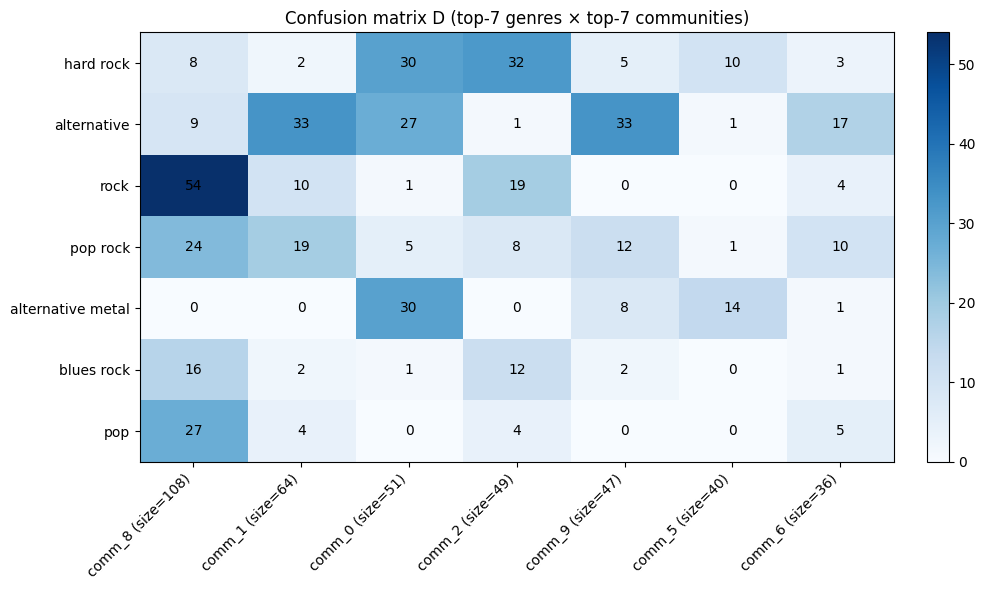

In [14]:
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ...existing code...

# ------------- Build confusion matrix D (7 genres x 7 communities) ----------------
# Get top-7 genres (counting every genre listed for each artist)
all_genres = []
for g in genres_dict.values():
    if g:
        all_genres.extend([gg.lower() for gg in g])
genre_counts = Counter(all_genres)
top7_genres = [g for g, _ in genre_counts.most_common(7)]

# Get top-7 structural communities (by size) from louvain_communities
comm_sizes = [(i, len(comm)) for i, comm in enumerate(louvain_communities)]
comm_sizes_sorted = sorted(comm_sizes, key=lambda x: x[1], reverse=True)
top7_comms = [cid for cid, _ in comm_sizes_sorted[:7]]

# Map community id -> column index
commid_to_col = {cid: idx for idx, cid in enumerate(top7_comms)}
genre_to_row = {genre: idx for idx, genre in enumerate(top7_genres)}

# Initialize D
D = np.zeros((7, 7), dtype=int)

# Fill D: for each node, if node belongs to one of top7 communities AND has at least one of top7 genres,
# increment counts for each matching genre (use all genres associated with node)
node_to_community = {}
for comm_id, comm in enumerate(louvain_communities):
    for node in comm:
        node_to_community[node] = comm_id

for node in G_genres.nodes():
    # check community membership
    if node not in node_to_community:
        continue
    comm_id = node_to_community[node]
    if comm_id not in commid_to_col:
        continue

    # check genres
    node_genres = genres_dict.get(node) or []
    # normalize to lowercase
    node_genres = [g.lower() for g in node_genres]
    matched = False
    for g in node_genres:
        if g in genre_to_row:
            D[genre_to_row[g], commid_to_col[comm_id]] += 1
            matched = True

# Build DataFrame for nicer display
comm_labels = [f"comm_{cid} (size={len(louvain_communities[cid])})" for cid in top7_comms]
df_D = pd.DataFrame(D, index=top7_genres, columns=comm_labels)


# Plot heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(df_D.values, cmap="Blues", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(df_D.columns)), df_D.columns, rotation=45, ha="right")
plt.yticks(range(len(df_D.index)), df_D.index)
plt.title("Confusion matrix D (top-7 genres × top-7 communities)")
# annotate cells
for i in range(df_D.shape[0]):
    for j in range(df_D.shape[1]):
        plt.text(j, i, df_D.iat[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()
# ...existing code...

## Genre Distribution Across Communities

The seven communities presented in the matrix are designed by extracting the seven most important communities from the first 7 out of 10 communities obtained using Louvain algorithm with resolution 1.5. Each band can belong to more than one genre, which explains why the sum of the genre columns often exceeds the total number of nodes within a community.

Since communities are not formed based on musical genres, we do not observe a single genre clearly dominating any community.  
Instead, the distribution of genres is spread across different categories within each community.

The node with the highest value appears in **Community 8**, which might initially seem to represent bands mainly associated with the **rock** genre.  
However, upon closer inspection, we also find a significant presence of **pop rock** and **pop** bands, showing that even this community is not purely genre-driven.


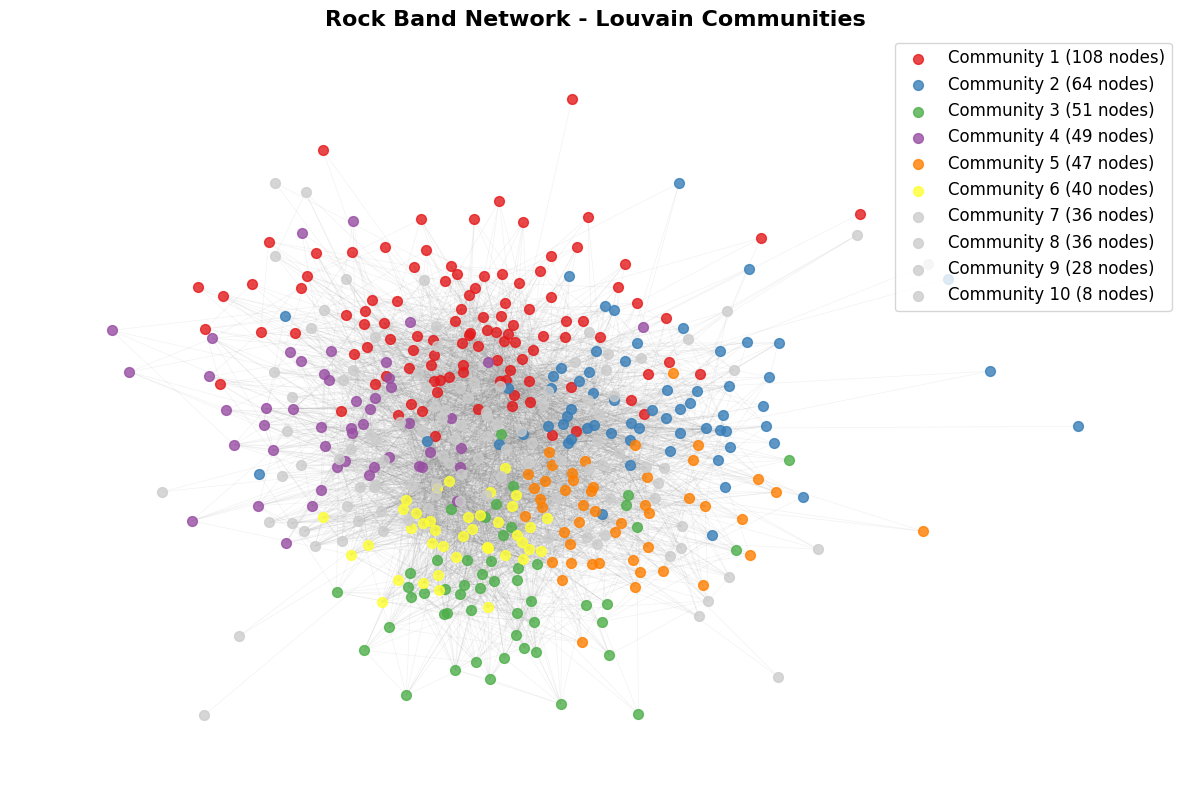

In [15]:
# VISUALIZE COMMUNITIES WITH FORCE ATLAS LAYOUT
# =============================================
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_genres, seed=42)

# Create figure
plt.figure(figsize=(12, 8))

# Assign colors to communities (top 4 communities get distinct colors)
colors = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#ffff33",
]

# Get the 4 communities sorted by size
sorted_communities = sorted(
    enumerate(louvain_communities),
    key=lambda x: len(x[1]),
    reverse=True,
)

# Draw each community
for idx, (comm_id, nodes_in_comm) in enumerate(sorted_communities):
    node_list = list(nodes_in_comm)
    nx.draw_networkx_nodes(
        G_genres,
        pos,
        nodelist=node_list,
        node_color=colors[idx] if idx < len(colors) else "#cccccc",
        node_size=50,
        alpha=0.8,
        label=f"Community {idx + 1} ({len(node_list)} nodes)",
    )

# Draw edges with low alpha
nx.draw_networkx_edges(G_genres, pos, alpha=0.1, width=0.5, edge_color="gray")

# Add labels for largest nodes (optional - can be removed if too cluttered)
# Get degree centrality
# degree_cent = nx.degree_centrality(G_genres)
# top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:20]
# labels = {node: node for node, _ in top_nodes}
# nx.draw_networkx_labels(G_genres, pos, labels, font_size=8, font_weight="bold")

plt.title(
    "Rock Band Network - Louvain Communities",
    fontsize=16,
    fontweight="bold",
)
plt.legend(loc="upper right", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
# ================================================
# ANALYZE GENRE DISTRIBUTION WITHIN EACH COMMUNITY
# ================================================
print("GENRE DISTRIBUTION WITHIN COMMUNITIES:")

for idx, (comm_id, nodes_in_comm) in enumerate(sorted_communities, 1):
    print(f"\nCOMMUNITY {idx} ({len(nodes_in_comm)} nodes)")
    print("-" * 80)

    # Collect all genres for nodes in this community
    community_genres = []
    for node in nodes_in_comm:
        if "genres" in G_genres.nodes[node]:
            community_genres.extend(G_genres.nodes[node]["genres"])

    # Count genre frequencies
    genre_counter = Counter(community_genres)
    top_genres = genre_counter.most_common(10)

    print("Top 10 genres:")
    for genre, count in top_genres:
        percentage = (count / len(nodes_in_comm)) * 100
        print(f"  {genre:25s}: {count:4d} occurrences ({percentage:5.1f}%)")

    # Show some example artists
    example_nodes = list(nodes_in_comm)[:5]
    print(f"\nExample artists: {', '.join(example_nodes)}")

print("\n" + "=" * 80)

GENRE DISTRIBUTION WITHIN COMMUNITIES:

COMMUNITY 1 (108 nodes)
--------------------------------------------------------------------------------
Top 10 genres:
  rock                     :   54 occurrences ( 50.0%)
  pop                      :   27 occurrences ( 25.0%)
  soft rock                :   24 occurrences ( 22.2%)
  pop rock                 :   24 occurrences ( 22.2%)
  folk rock                :   22 occurrences ( 20.4%)
  country rock             :   17 occurrences ( 15.7%)
  blues rock               :   16 occurrences ( 14.8%)
  country                  :   10 occurrences (  9.3%)
  alternative              :    9 occurrences (  8.3%)
  rockabilly               :    9 occurrences (  8.3%)

Example artists: Foster the People, Traveling Wilburys, Kenny Loggins, Ringo Starr, Chubby Checker

COMMUNITY 2 (64 nodes)
--------------------------------------------------------------------------------
Top 10 genres:
  alternative              :   33 occurrences ( 51.6%)
  indie        